#### Find best $N_0$ 
Compute coherent cross section for fixed $N_0$, calculate $\chi^2$.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [ ]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")
include("../src/data.jl")

read_coherent_data (generic function with 1 method)

In [4]:
params_run_local = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape, p_run=params_run_local)

In [5]:
Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
Nsamples = params_shape.Nsamples
t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", Δ_range, Nsamples, params_run_local, Nsamples)

Computed cross sections for path: ../results/testnorm


([0.0, 0.0625, 0.25, 0.5625, 1.0], [197.120678277359, 148.9208790820196, 64.22201031849774, 15.506012746217742, 2.185804549883983], [0.6717482372652779, 0.48455941114338175, 0.309885303801215, 0.23554906449414373, 0.0879072116047418], [0.0022891849713293486, 0.0015766615425513732, 0.0014952646457877528, 0.0035781836821778823, 0.0035353928842958575], [0.6709524913149265, 0.4252216591628353, 0.22096038618109617, 0.18012984634951948, 0.07979999940940732])

In [1]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

LoadError: UndefVarError: `read_coherent_data` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

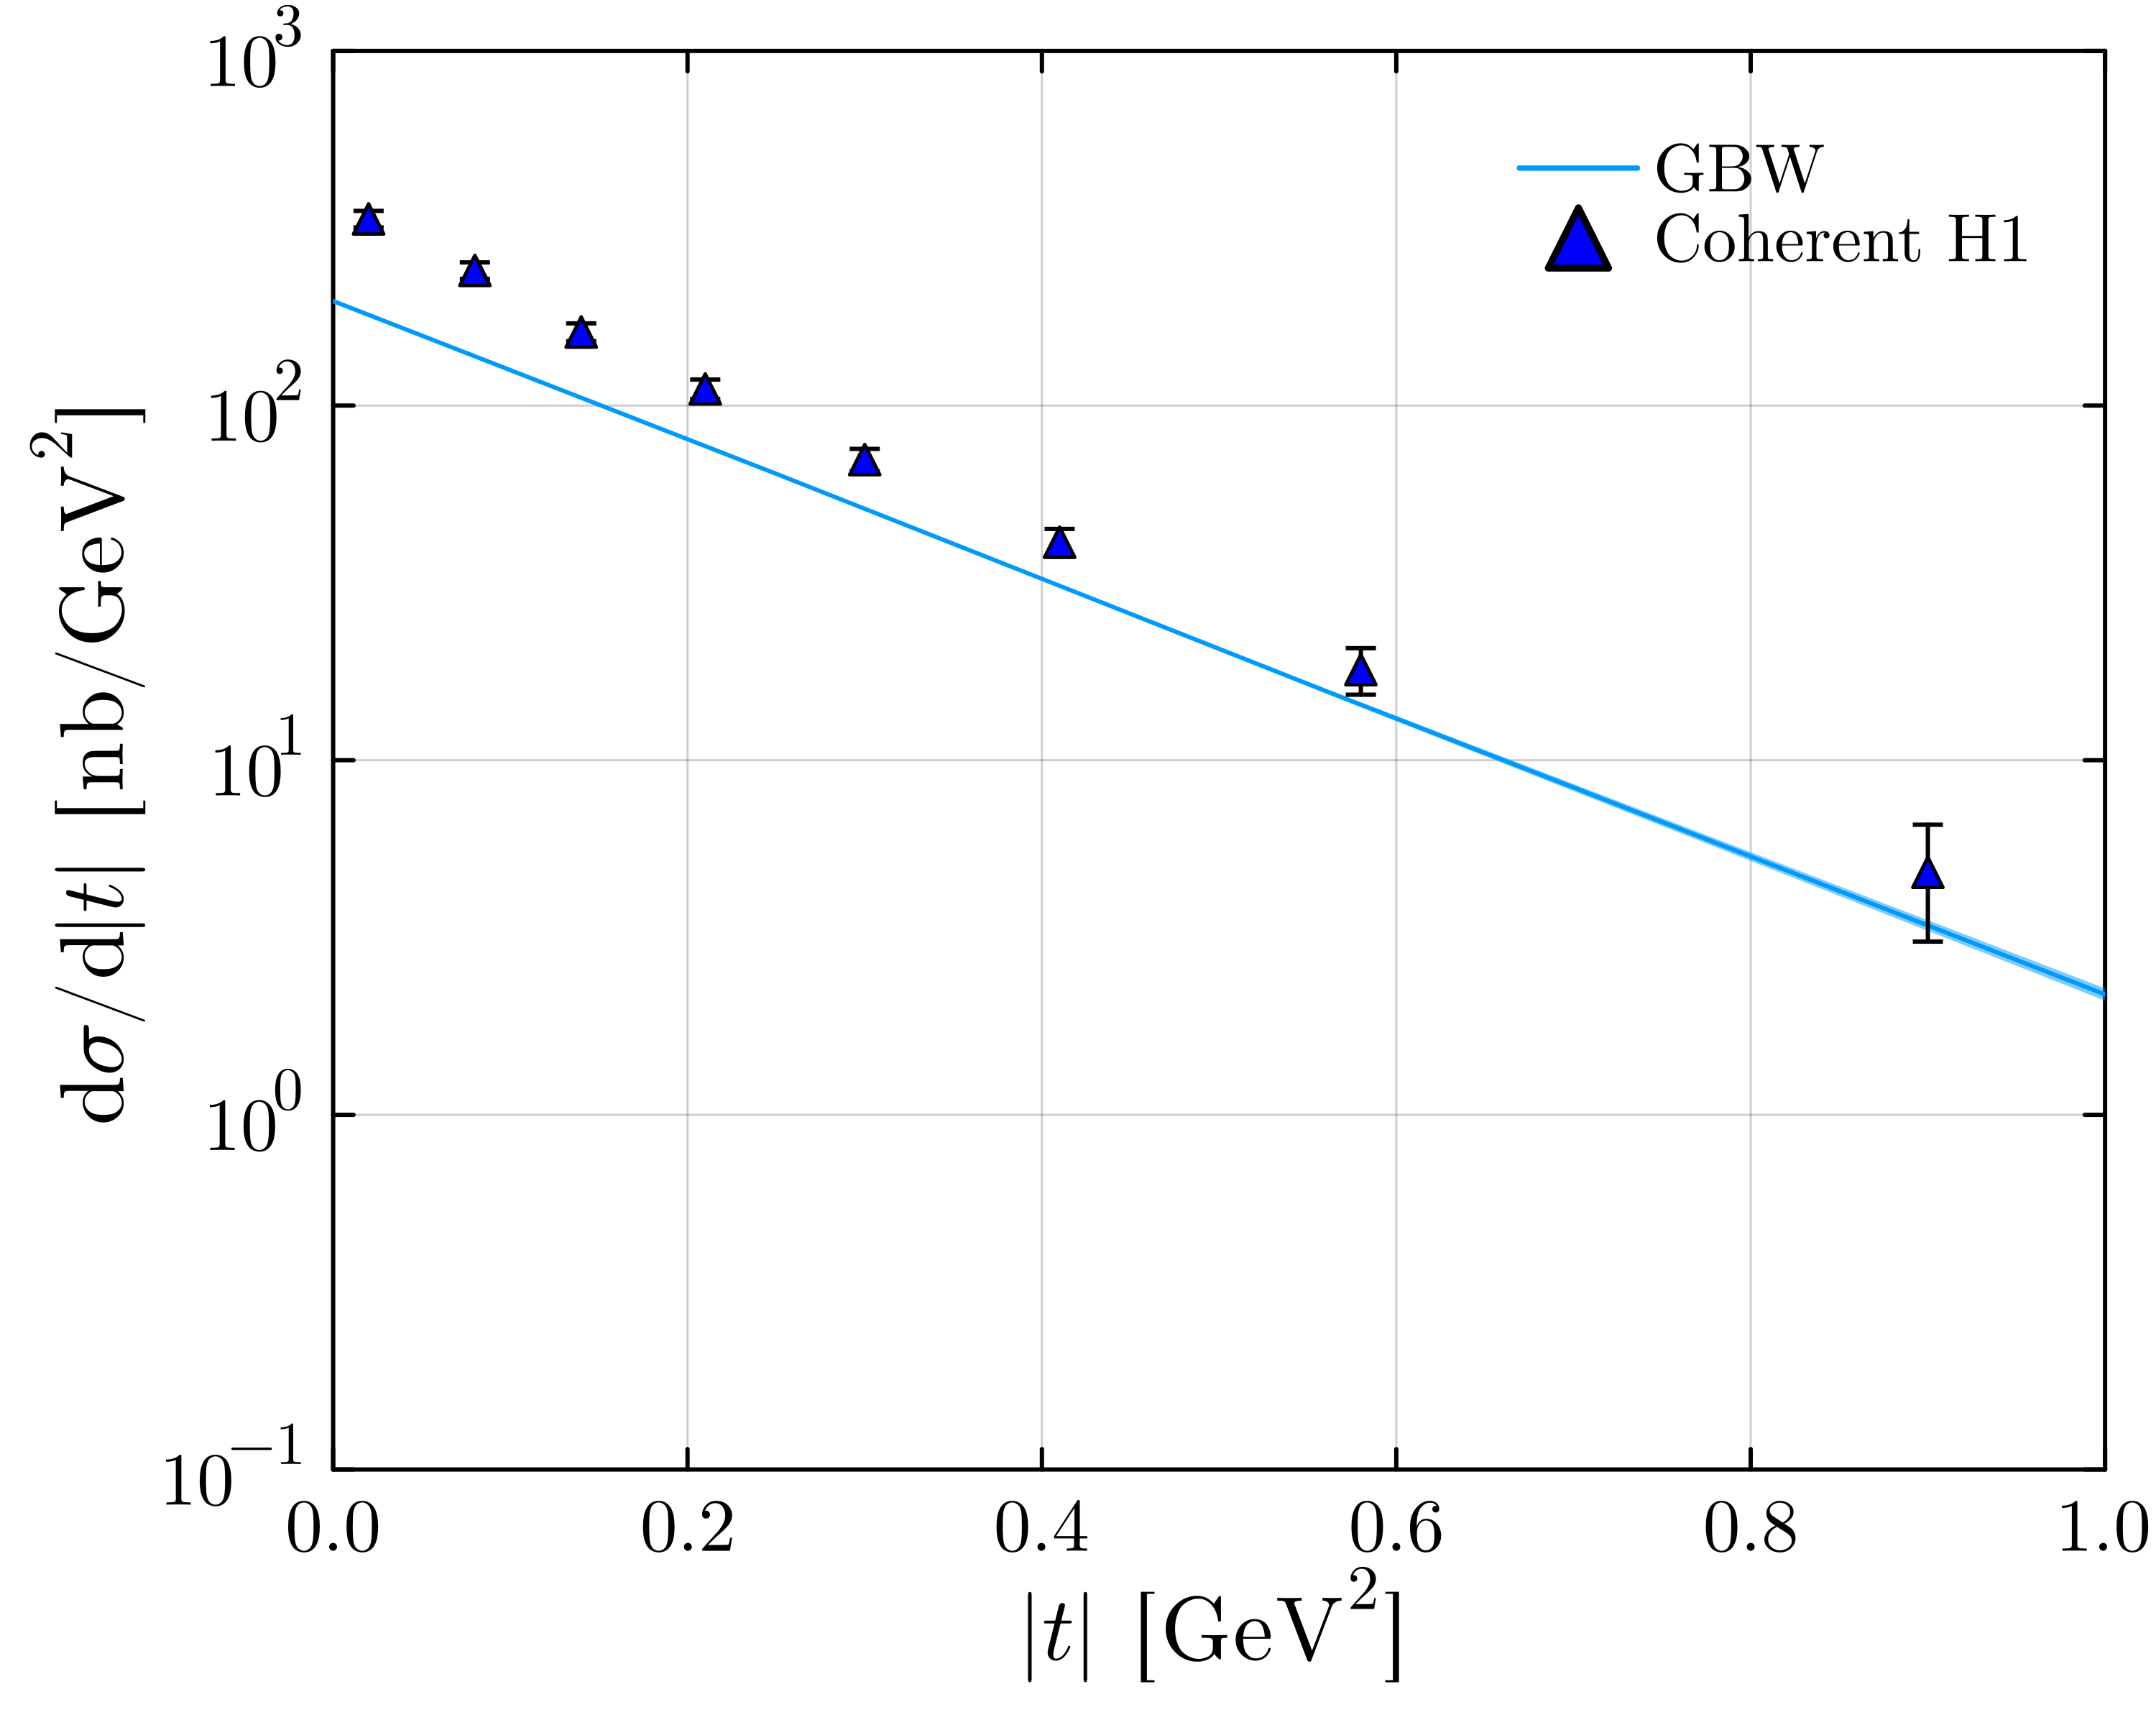

In [7]:
data = CoherentMCData(t_range, dσdt_coh, dσdt_coh_err, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
p = plot(data)
ylims!(p, (0.1, 1000))

In [ ]:
using Interpolations
using Optim

In [9]:
model_interp = LinearInterpolation(t_range, dσdt_coh)
model_at_data = model_interp(tcent_coh_hera)

# Compute chi-squared
chisq = sum(((model_at_data .- dσdt_coh_hera) ./ Δtot_coh_hera).^2)
ndof = length(dσdt_coh_hera)  
chisq_per_dof = chisq / ndof

println("Chi-squared: ", chisq)
println("Chi-squared per d.o.f.: ", chisq_per_dof)

Chi-squared: 185.1919410350547
Chi-squared per d.o.f.: 23.148992629381837


In [ ]:
function optimal_norm(N₀_values, params_shape, params_wavefct, params_mc, params_run_local)
    best_χsq = Inf
    best_N₀ = nothing
    χsq_list = Float64[]
    N₀_list = Float64[]
    
    for N₀_val in N₀_values
        params_shape_norm = merge(params_shape, (N₀ = N₀_val,))

        diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_norm, p_run=params_run_local)
        Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
        Nsamples = params_shape.Nsamples
        t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", Δ_range, Nsamples, params_run_local, Nsamples)
        tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")

        model_interp = LinearInterpolation(t_range, dσdt_coh)
        model_at_data = model_interp(tcent_coh_hera)

        χsq = sum(((model_at_data .- dσdt_coh_hera) ./ Δtot_coh_hera).^2)
        push!(χsq_list, χsq)
        push!(N₀_list, N₀_val)

        if χsq < best_χsq
            best_χsq = χsq
            best_N₀ = N₀_val
        end
    end

    return best_N₀, best_χsq, N₀_list, χsq_list
end

N₀_values = 0.1:0.4:2.0  
best_N₀, best_χsq, N₀_list, χsq_list = optimal_norm(N₀_values, params_shape, params_wavefct, params_mc, params_run_local)
println("Best N₀: ", best_N₀, " with χ²: ", best_χsq)

In [6]:
best_N₀, best_χsq, N₀_list, χsq_list

(1.3, 93.61887339576921, [0.1, 0.5, 0.9, 1.3, 1.7], [1593.0119727165513, 1094.8680119873723, 336.29175896961823, 93.61887339576921, 1412.4338576857651])

---

#### Find optimal $N_0$ 
Seek optimal $N_0$ which gives the best $\chi^2$ for coherent cross section. This would work best with GPEs, at the moment too slow.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")
include("../src/data.jl")

read_coherent_data (generic function with 1 method)

In [4]:
# params_run_local = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "testnorm/")
params_run_local = (run = "local", savefile = true, run_threads = false, savepath = "../results/", outdir = "testnorm/")

(run = "local", savefile = true, run_threads = false, savepath = "../results/", outdir = "testnorm/")

In [5]:
using Optim
using Interpolations

In [6]:
function chisq_for_N₀(N₀, params_shape, params_wavefct, params_mc, params_run_local)
    params_shape_norm = merge(params_shape, (N₀ = N₀,))
    diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_norm, p_run=params_run_local)
    Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
    Nsamples = params_shape_norm.Nsamples
    t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", Δ_range, Nsamples, params_run_local, Nsamples)
    tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
    model_interp = LinearInterpolation(t_range, dσdt_coh)
    model_at_data = model_interp(tcent_coh_hera)
    chisq = sum(((model_at_data .- dσdt_coh_hera) ./ Δtot_coh_hera).^2)
    return chisq
end

function find_best_N₀(params_shape, params_wavefct, params_mc, params_run_local; initial_guess=1.0, lower=0.1, upper=3.0)
    obj = N₀ -> chisq_for_N₀(N₀, params_shape, params_wavefct, params_mc, params_run_local)
    result = optimize(obj, lower, upper, Brent())
    best_N₀ = Optim.minimizer(result)
    best_χsq = Optim.minimum(result)
    return best_N₀, best_χsq
end

find_best_N₀ (generic function with 1 method)

In [ ]:
chisq_for_N₀(1.0, params_shape, params_wavefct, params_mc, params_run_local)

In [ ]:
best_N₀, best_χsq = find_best_N₀(params_shape, params_wavefct, params_mc, params_run_local)
println("Best N₀: ", best_N₀, " with χ²: ", best_χsq)

---

#### Find best $N_0$ at $t=0$
Seek optimal $N_0$ which gives the best $\chi^2$ for coherent cross section only at $t=0$. 

In [5]:
function optimal_norm_N0(N₀_values, params_shape, params_wavefct, params_mc, params_run_local)
    best_χsq = Inf
    best_N₀ = nothing
    χsq_list = Float64[]
    N₀_list = Float64[]

    for N₀_val in N₀_values
        params_shape_norm = merge(params_shape, (N₀ = N₀_val,))
        Δ_val = 0.0
        params_mc_Δ_val = merge(params_mc, (Δmin = 0.0, Δmax = 0.0, Δlen = 1))

        diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc_Δ_val; p_shape=params_shape_norm, p_run=params_run_local, Δ_values=[Δ_val])

        Nsamples = params_shape.Nsamples

        t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err = compute_cross_sections("../results/testnorm", [Δ_val], Nsamples, params_run_local, Nsamples)

        tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")

        model_val = dσdt_coh[1]
        data_val = dσdt_coh_hera[1]
        data_err = Δtot_coh_hera[1]

        χsq = ((model_val - data_val) / data_err)^2

        push!(χsq_list, χsq)
        push!(N₀_list, N₀_val)

        if χsq < best_χsq
            best_χsq = χsq
            best_N₀ = N₀_val
        end
    end

    return best_N₀, best_χsq, N₀_list, χsq_list
end

optimal_norm_N0 (generic function with 1 method)

In [ ]:
N₀_values = 0.0:0.5:2.0
best_N₀, best_χsq, N₀_list, χsq_list = optimal_norm_N0(N₀_values, params_shape, params_wavefct, params_mc, params_run_local)
println("Best N₀ at Δ=0: ", best_N₀, " with χ²: ", best_χsq)

In [7]:
N₀_list

5-element Vector{Float64}:
 0.0
 0.5
 1.0
 1.5
 2.0

In [8]:
best_N₀

1.5

---

In [6]:
# Compute χ² at Δ=0 for a given N₀
function chisq_for_N₀_at_Δ0(N₀, params_shape, params_wavefct, params_mc, params_run_local; unique_outdirs=false)
    try
        params_shape_norm = merge(params_shape, (N₀ = N₀,))
        params_mc_Δ0 = merge(params_mc, (Δmin = 0.0, Δmax = 0.0, Δlen = 1))

        # Optionally isolate outputs per N₀ to avoid file collisions
        p_run_iter = if unique_outdirs
            outdir = joinpath(params_run_local.outdir, "N0_$(round(N₀; digits=6))")
            merge(params_run_local, (outdir = outdir,))
        else
            params_run_local
        end

        # Run the forward model at Δ=0 only
        diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc_Δ0; p_shape=params_shape_norm, p_run=p_run_iter)

        # Where compute_cross_sections will read results from
        compute_dir = joinpath(p_run_iter.savepath, p_run_iter.outdir)
        endswith(compute_dir, "/") && (compute_dir = compute_dir[1:end-1])

        Nsamples = params_shape.Nsamples
        t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err =
            compute_cross_sections(compute_dir, [0.0], Nsamples, p_run_iter, Nsamples)

        tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")

        model_val = dσdt_coh[1]
        data_val  = dσdt_coh_hera[1]
        data_err  = Δtot_coh_hera[1]

        χsq = ((model_val - data_val) / data_err)^2

        return isfinite(χsq) ? χsq : Inf
    catch
        return Inf
    end
end


chisq_for_N₀_at_Δ0 (generic function with 1 method)

In [7]:
# Adaptive search starting at N₀=1.0 that can go lower or higher
function find_best_N₀_at_Δ0_adaptive(params_shape, params_wavefct, params_mc, params_run_local;
    start=1.0, step_factor=1.6, min_N0=1e-3, max_N0=10.0, max_expansions=20,
    verbose=true, unique_outdirs=false, brent_reltol=1e-3)

    # Cache to avoid recomputation
    cache = Dict{Float64,Float64}()
    obj(N) = get!(cache, N) do
        chisq_for_N₀_at_Δ0(N, params_shape, params_wavefct, params_mc, params_run_local; unique_outdirs=unique_outdirs)
    end

    # Evaluate at start
    x0 = clamp(start, min_N0, max_N0)
    f0 = obj(x0)
    verbose && println("Start N₀=$x0 → χ²=$f0")

    # Expand upwards
    xr, fr = x0, f0
    n = 0
    while n < max_expansions
        xtry = clamp(xr * step_factor, min_N0, max_N0)
        if xtry == xr; break; end
        ftry = obj(xtry)
        verbose && println("  up: N₀=$xtry → χ²=$ftry")
        if ftry < fr
            xr, fr = xtry, ftry
            n += 1
        else
            break
        end
    end
    up_bracket = (xr, fr)

    # Expand downwards
    xl, fl = x0, f0
    n = 0
    while n < max_expansions
        xtry = clamp(xl / step_factor, min_N0, max_N0)
        if xtry == xl; break; end
        ftry = obj(xtry)
        verbose && println("down: N₀=$xtry → χ²=$ftry")
        if ftry < fl
            xl, fl = xtry, ftry
            n += 1
        else
            break
        end
    end
    down_bracket = (xl, fl)

    # Build a bracket [a,b] that contains the best among {xl, x0, xr}
    a = min(xl, xr); b = max(xl, xr)
    # Ensure a < b with some span
    if a == b; a = max(min_N0, x0/step_factor); b = min(max_N0, x0*step_factor); end

    # Refine with Brent in [a,b]
    result = optimize(obj, a, b, Brent(); rel_tol=brent_reltol)
    best_N₀ = Optim.minimizer(result)
    best_χsq = Optim.minimum(result)
    verbose && println("Brent in [$a,$b] → N₀=$best_N₀, χ²=$best_χsq")

    return best_N₀, best_χsq, (a,b), cache
end

find_best_N₀_at_Δ0_adaptive (generic function with 1 method)

In [ ]:
best_N₀, best_χsq, bracket, evals = find_best_N₀_at_Δ0_adaptive(params_shape, params_wavefct, params_mc, params_run_local; start=1.0, min_N0=1e-3, max_N0=1e3, step_factor=0.1, unique_outdirs=false)
println("Best N₀ at Δ=0: ", best_N₀, " with χ²: ", best_χsq)

In [8]:
best_N₀, best_χsq

(1.3220745341265232, 0.03323753086744089)

---

In [ ]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:

include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
params_run_local = (run = "local", savefile = true, run_threads = false, savepath = "../results", outdir = "testnorm/")

(run = "local", savefile = true, run_threads = false, savepath = "../results", outdir = "testnorm/")

In [ ]:
find_best_N₀_at_Δ₀_adaptive(params_shape, params_wavefct, params_mc, params_run_local, params_norm)

In [ ]:
println("chisq at 1.0 = ", chisq_for_N₀_at_Δ₀(1.0, params_shape, params_wavefct, params_mc, params_run_local, params_norm))

---
#### Check $T_p<0$ 
Check if thickness function becomes negative, replace with $0$ when it does, check effect on cross sections.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")
include("../src/data.jl")

read_coherent_data (generic function with 1 method)

In [3]:
params_shape_notp = merge(params_shape, (checktp = true,), (replacetp = false,), (σ = 10.0,))
params_run_local_notp = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_notp_sigma_10.0/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_notp_sigma_10.0/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_notp, p_run=params_run_local_notp)

In [9]:
params_shape_tp = merge(params_shape, (checktp = true,), (replacetp = true,), (σ = 10.0,))
params_run_local_tp = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_tp_sigma_10.0/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_tp_sigma_10.0/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_tp, p_run=params_run_local_tp)

In [5]:
params_shape_tp_mod = merge(params_shape, (checktp = true,), (replacetp = true, typetp = "mod"), (σ = 10.0,))
params_run_local_tp_mod = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_tp_mod_sigma_10.0/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_tp_mod_sigma_10.0/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape_tp_mod, p_run=params_run_local_tp_mod)

In [7]:
Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
Nsamples = params_shape.Nsamples

10

In [10]:
t_range, dσdt_coh_notp, dσdt_coh_err_notp, dσdt_incoh_notp, dσdt_incoh_err_notp = compute_cross_sections("../results/test_notp_sigma_10.0", Δ_range, Nsamples, params_run_local_notp, Nsamples)
t_range, dσdt_coh_tp, dσdt_coh_err_tp, dσdt_incoh_tp, dσdt_incoh_err_tp = compute_cross_sections("../results/test_tp_sigma_10.0", Δ_range, Nsamples, params_run_local_tp, Nsamples)
t_range, dσdt_coh_tp_mod, dσdt_coh_err_tp_mod, dσdt_incoh_tp_mod, dσdt_incoh_err_tp_mod = compute_cross_sections("../results/test_tp_mod_sigma_10.0", Δ_range, Nsamples, params_run_local_tp_mod, Nsamples)

Computed cross sections for path: ../results/test_notp_sigma_10.0
Computed cross sections for path: ../results/test_tp_sigma_10.0
Computed cross sections for path: ../results/test_tp_mod_sigma_10.0


([0.0, 0.0625, 0.25, 0.5625, 1.0], [2071.1562111775465, 1613.8712669621532, 764.6626864884219, 232.93324803195893, 45.36380609869051], [9.31274001851279, 5.737366026744799, 2.863142147290003, 1.7991024791775474, 0.8507756237930817], [0.09421599100837803, 0.04589218582506491, 0.02412117391871624, 0.031265317232909796, 0.0359007158933715], [9.305286837977635, 5.4990149074555665, 2.4312343725585728, 1.6718345739019933, 0.5571920846003041])

In [11]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

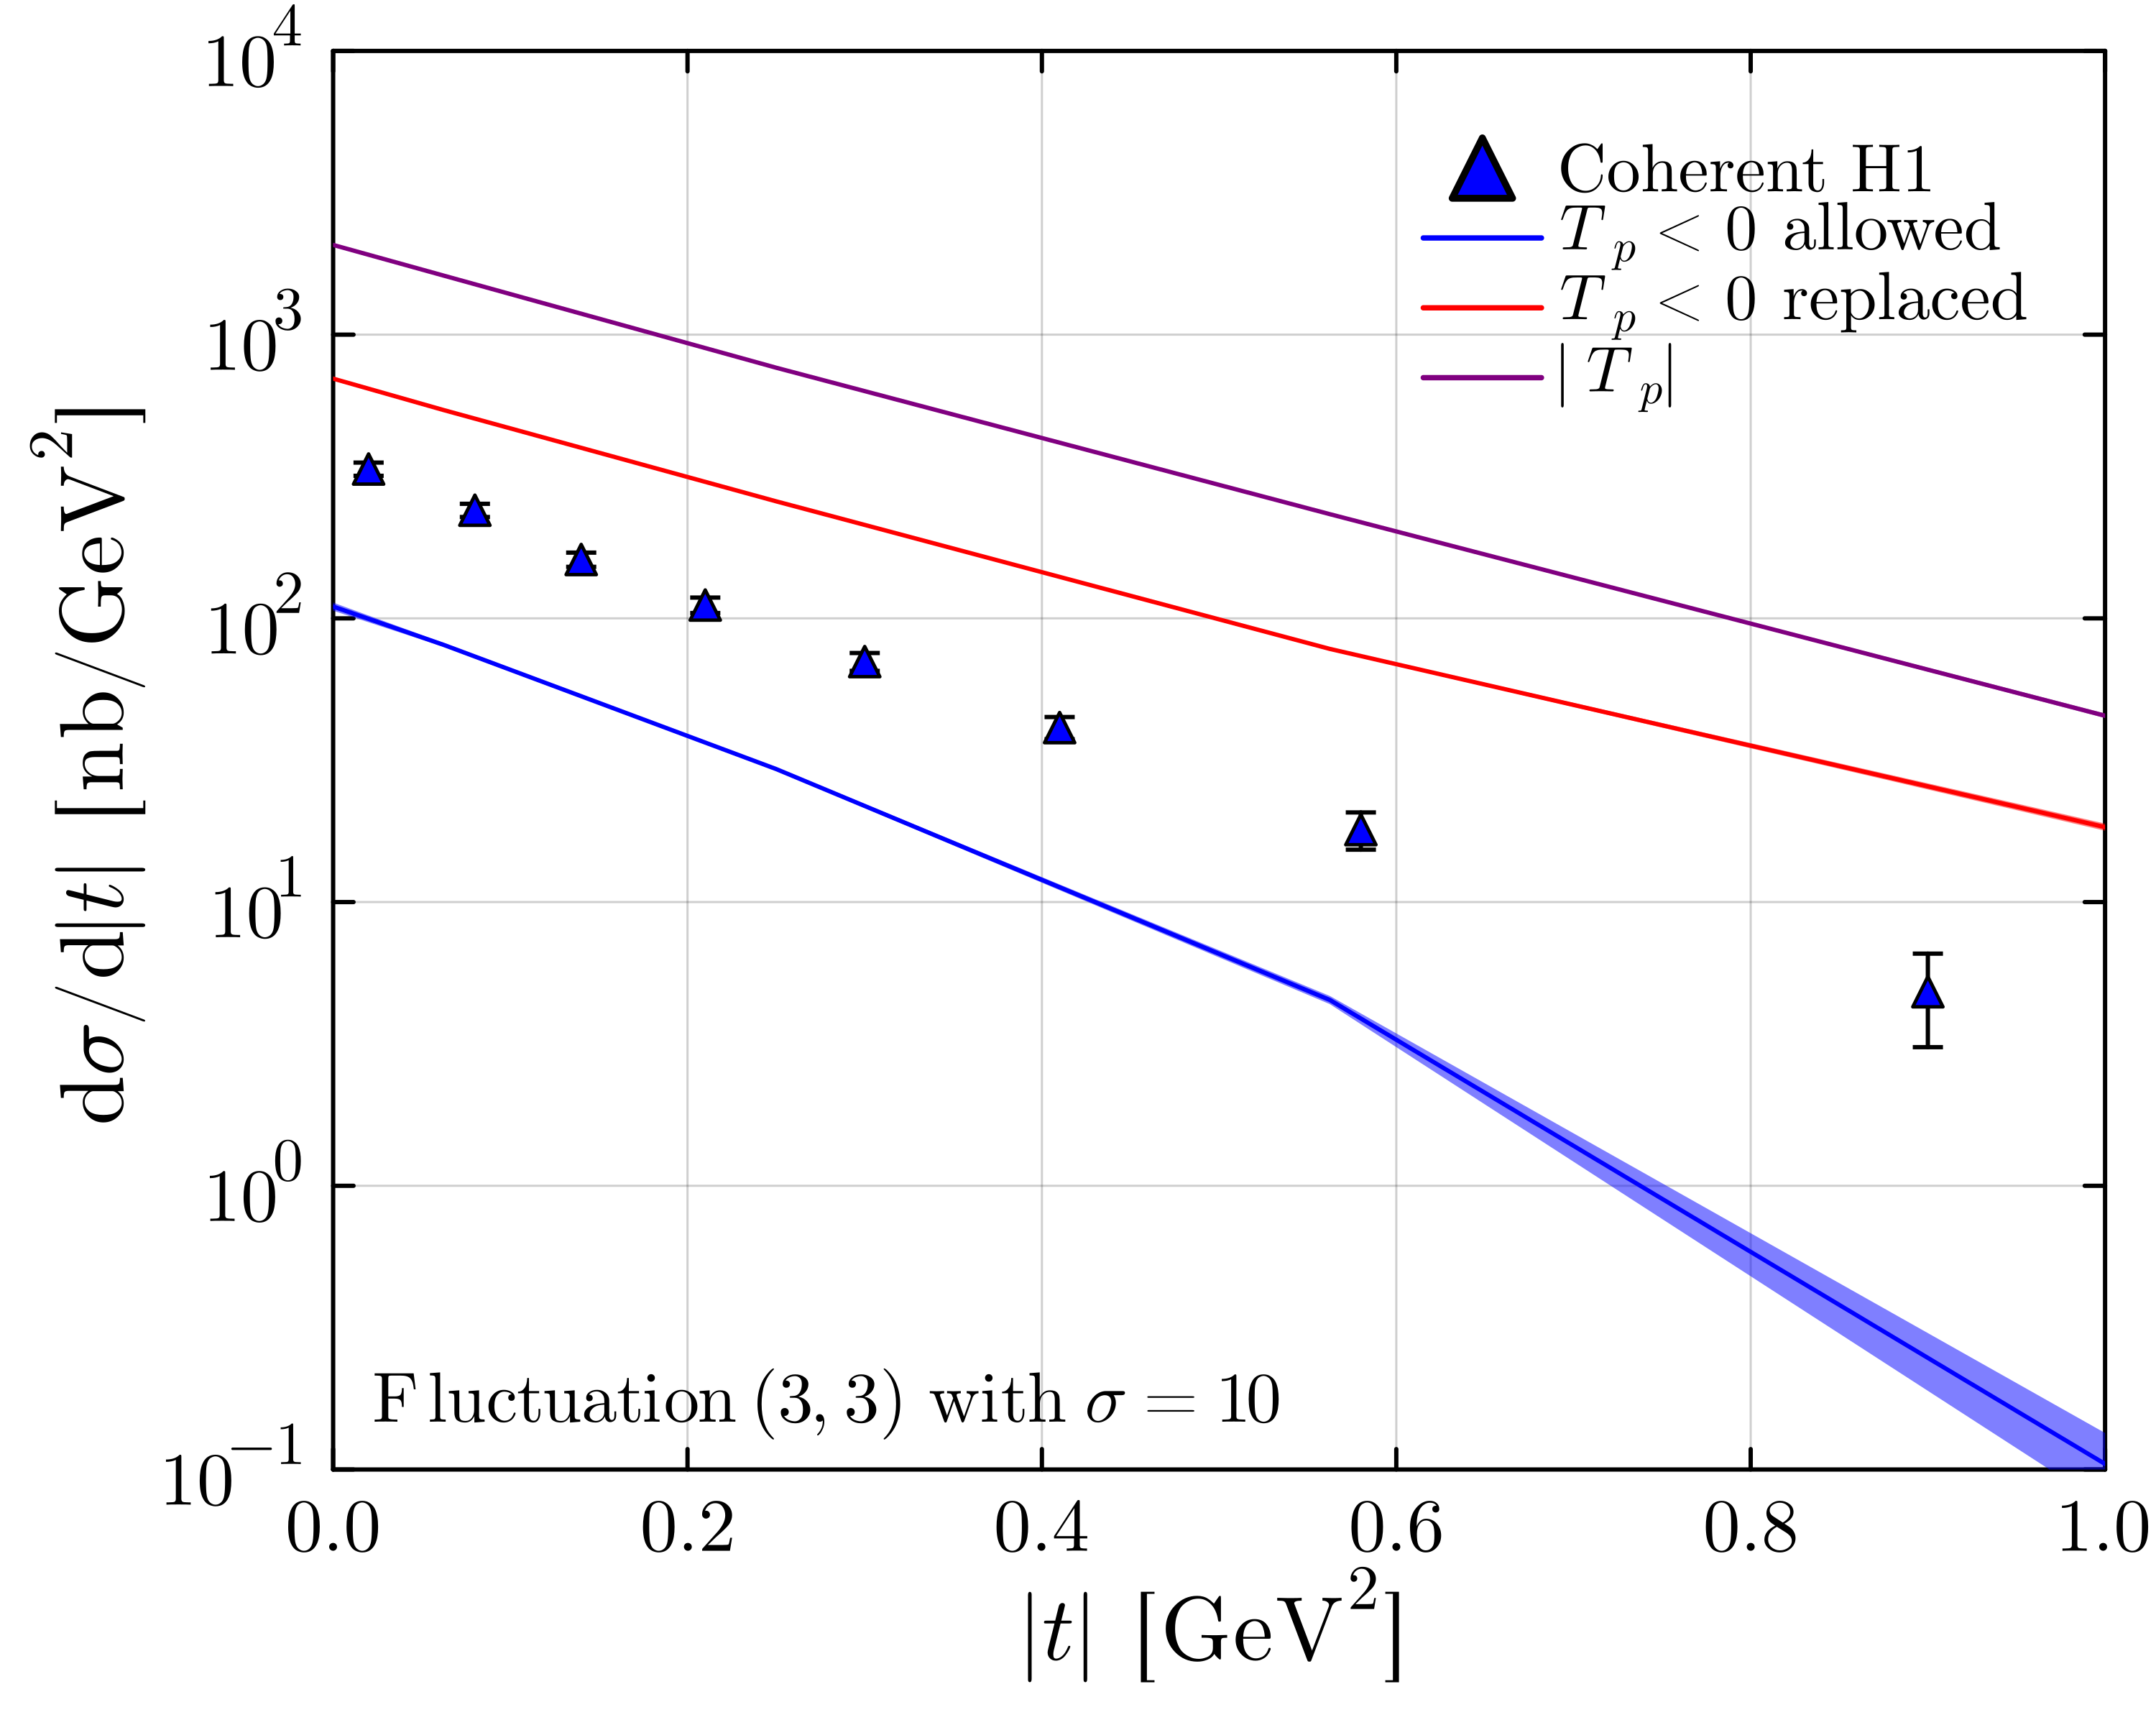

In [ ]:
# data_notp = CohIncohMCData(t_range, dσdt_coh_notp, dσdt_coh_err_notp, dσdt_incoh_notp, dσdt_incoh_err_notp, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera, tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera)
data_notp = CoherentMCData(t_range, dσdt_coh_notp, dσdt_coh_err_notp, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
data_tp = CoherentMCData(t_range, dσdt_coh_tp, dσdt_coh_err_tp, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
data_tp_mod = CoherentMCData(t_range, dσdt_coh_tp_mod, dσdt_coh_err_tp_mod, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
p = plot(data_notp; custom_label = "\$T_p<0\$ allowed", color = :blue)
plot!(p, data_tp; custom_label = "\$T_p<0\$ replaced", color=:red, hera=false)
plot!(p, data_tp_mod; custom_label = "\$|T_p| \$", color=:purple, hera=false)
ylims!(p, (0.1, 10000))
annotate!(p, 0.28, 0.17, text(L"\mathrm{Fluctuation}~(3,3)~\mathrm{with}~\sigma=10", :black, 11))

In [17]:
savefig(p, "../plots/jpsi_coh_incoh_hera_sigma_10.0_negtp_modtp.png")

"/Users/dana/Work/protonshape/plots/jpsi_coh_incoh_hera_sigma_10.0_negtp_modtp.png"

---

#### Plot without $T_p<0$ 
Check if thickness function becomes negative, replace with $0$ when it does, vizualize.

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")

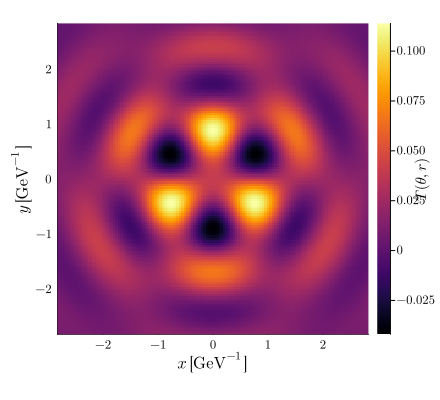

In [9]:
sg = SingleConfiguration(coeff_dict=Dict((3, 3) => 5.0), L=√8, Nx=128, Ny=128, func_type="Tp", a=√8, env_func=gaussenv, α=4, checktp=false)
sg = plot(sg)

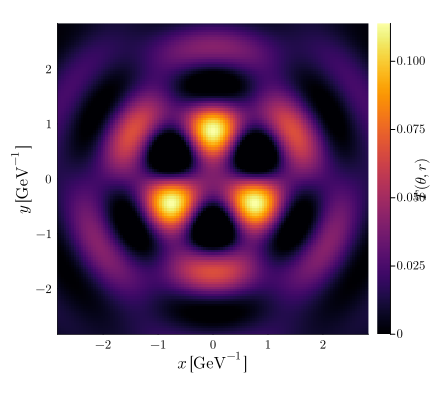

In [8]:
sg = SingleConfiguration(coeff_dict=Dict((3, 3) => 5.0), L=√8, Nx=128, Ny=128, func_type="Tp", a=√8, env_func=gaussenv, α=4, checktp=true)
sg = plot(sg)

---
#### Find best $N_0$ from batch runs

In [4]:
using JLD2

# m, n = 3, 4
dir = "../results"

norms = Float64[]
for file in readdir(dir)
    # m = match(r"^cross_sections_mn_31_sigma_(.*)\.jld2$", file)
    m = match(r"cross_sections_m_3_nmax_3_norm_sigma_1.0_N0_(.*)\.jld2$", file)
    if m !== nothing
        push!(norms, parse(Float64, m.captures[1]))
    end
end

In [5]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

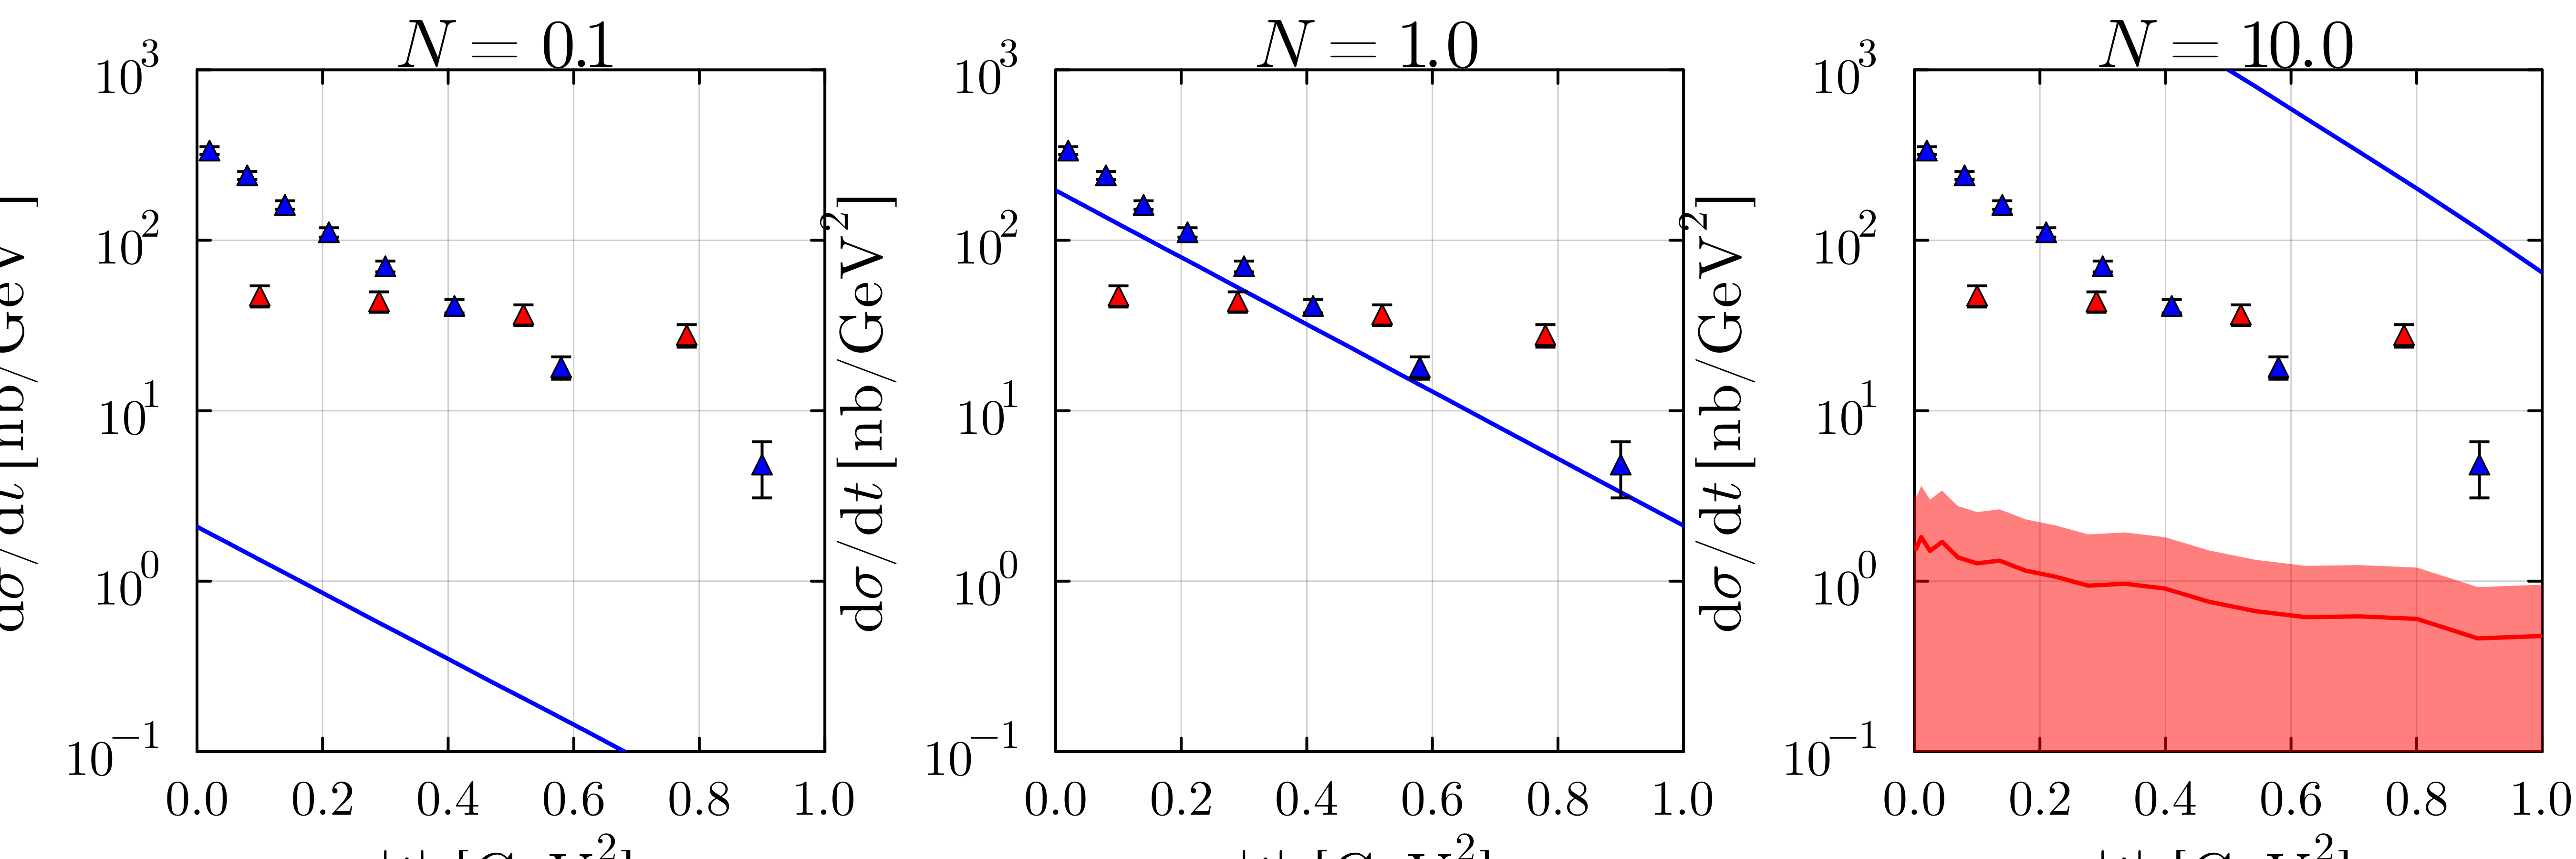

In [8]:
plot_grid = []
norms_sort = sort(norms)
for norm in norms_sort
    # data = JLD2.load("../results/cross_sections_mn_31_sigma_"*string(σ)*".jld2")
    data = JLD2.load("../results/cross_sections_m_3_nmax_3_norm_sigma_1.0_N0_"*string(norm)*".jld2")
    # data = JLD2.load("../results/cross_sections_m_3_nmax_3_norm_sigma_5.0_N0_"*string(norm)*".jld2")

    dσdt_incoh_err, dσdt_coh_err, t_range, dσdt_coh, dσdt_incoh = data["dσdt_incoh_err"], data["dσdt_coh_err"], data["t_range"], data["dσdt_coh"], data["dσdt_incoh"]
    
    data_cohincoh = CohIncohMCData(t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera, tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera)
    
    p = plot(data_cohincoh, legend=false, title=L"N=%$norm", titlefontsize=16)

    push!(plot_grid, p)
end

plt = plot(plot_grid..., layout=(1, 3), size=(900, 300))
xlims!(plt, (0, 1))
# savefig(plt, "../plots/cohincoh_m_3_nmax_3_fine_sigma_dep.png")
display(plt)

---
#### Optimal $N_0$ vary $\sigma$

In [36]:
using JLD2

# m, n = 3, 4
dir = "../results"

sigmas = Float64[]
for file in readdir(dir)
    # m = match(r"^cross_sections_mn_31_sigma_(.*)\.jld2$", file)
    m = match(r"cross_sections_m_3_nmax_4_find_norm_replacetp_sigma_(.*)_N0.jld2$", file)
    if m !== nothing
        push!(sigmas, parse(Float64, m.captures[1]))
    end
end

In [37]:
sigmas

2-element Vector{Float64}:
 1.0
 5.0

In [38]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

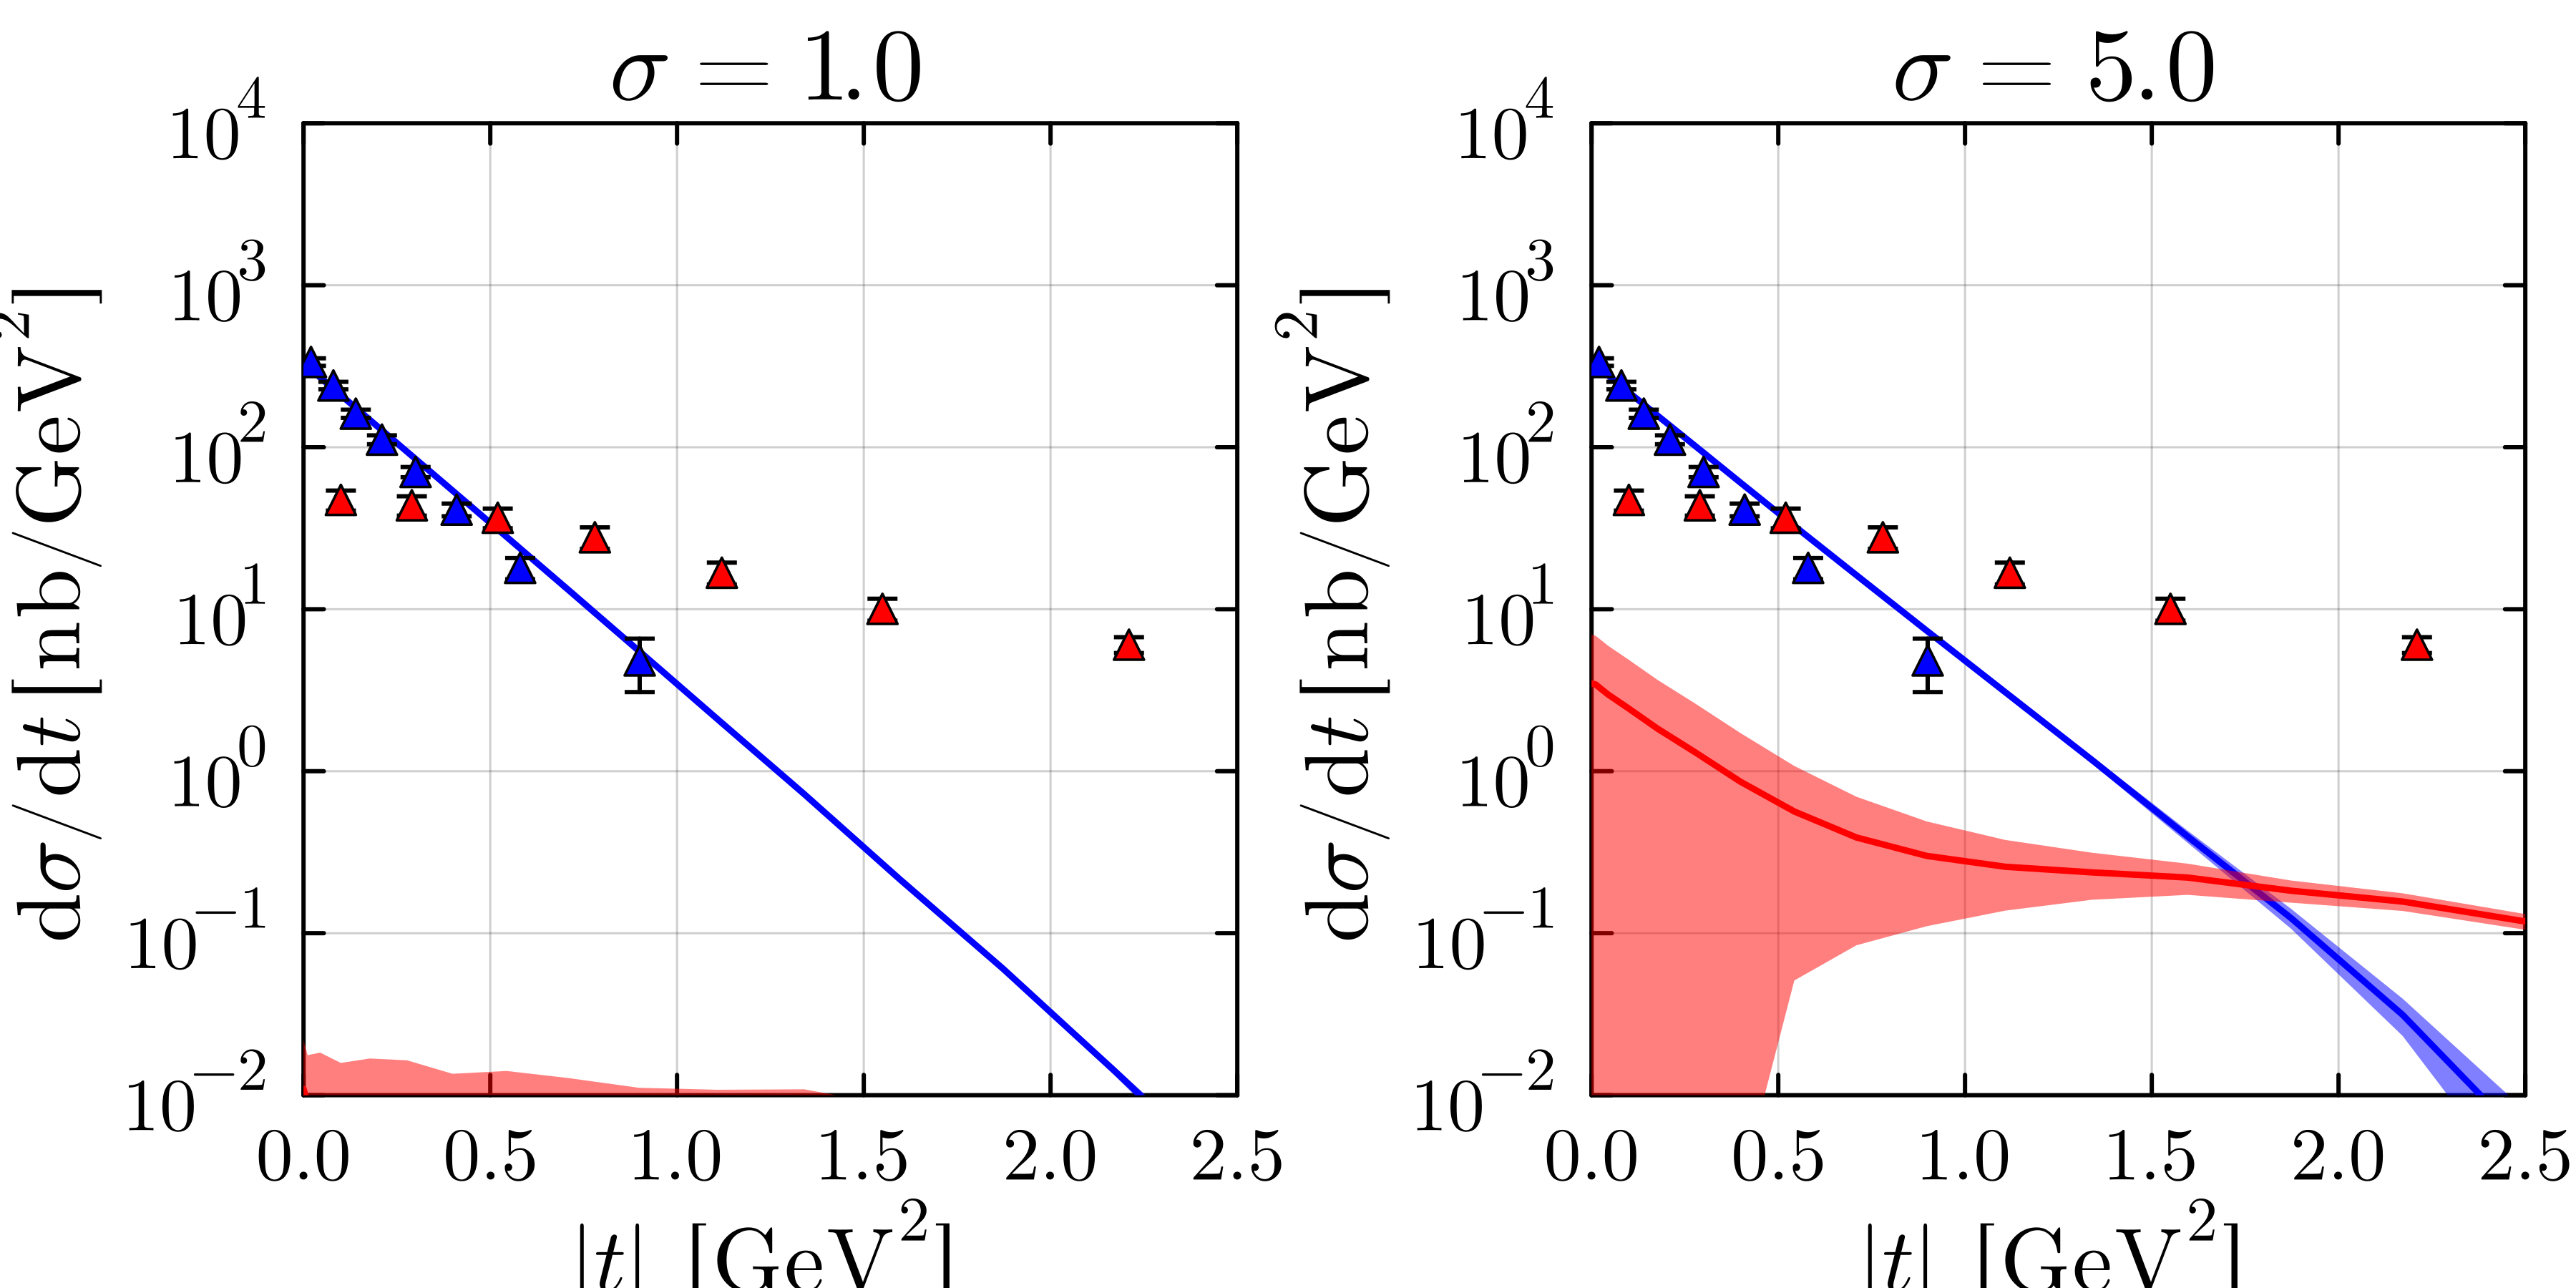

In [41]:
plot_grid = []
sigmas_sort = sort(sigmas)
for sigma in sigmas_sort
    data = JLD2.load("../results/cross_sections_m_3_nmax_4_find_norm_replacetp_sigma_"*string(sigma)*"_N0.jld2")

    dσdt_incoh_err, dσdt_coh_err, t_range, dσdt_coh, dσdt_incoh = data["dσdt_incoh_err"], data["dσdt_coh_err"], data["t_range"], data["dσdt_coh"], data["dσdt_incoh"]
    
    data_cohincoh = CohIncohMCData(t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera, tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera)

    p = plot(data_cohincoh, legend=false, title=L"\sigma=%$sigma", titlefontsize=16)

    push!(plot_grid, p)
end

plt = plot(plot_grid..., layout=(1, 2), size=(600, 300))
# xlims!(plt, (0, 1))
ylims!(plt, (0.01, 10000))
savefig(plt, "../plots/cohincoh_m_3_nmax_4_find_norm_sigma_dep.png")
display(plt)

---
#### Check $r_\mathrm{max}$ dependence

In [1]:
import Pkg
Pkg.activate("/Users/dana/Work/protonshape")

  Activating project at `~/Work/protonshape`


In [2]:
include("../src/ProtonShape.jl")
using .ProtonShape

In [3]:
include("../src/plotrecipes.jl")
include("../src/data.jl")

read_coherent_data (generic function with 1 method)

In [4]:
params_shape_rmax_1 = merge(params_shape, (checktp = true,), (replacetp = true,), (σ = 10.0,))
params_run_local_rmax_1 = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_sigma_10.0_rmax_1/")

(run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_sigma_10.0_rmax_1/")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc; p_shape=params_shape, p_run=params_run_local_rmax_1)

In [ ]:
params_run_local_rmax_10 = (run = "local", savefile = true, run_threads = true, savepath = "../results/", outdir = "test_sigma_10.0_rmax_10/")
ħcinv = 5.068 # convert fm^-1 to GeV
params_mc_rmax_10 = merge(params_mc, (rmax = 10* ħcinv,))

(rmin = 0.0, rmax = 50.67999999999999, bmin = 0.0, bmax = 50.67999999999999, zmin = 0.0, zmax = 1.0, θbmin = 0.0, θbmax = 6.283185307179586, Δmin = 0.0, Δmax = 2.0, Δlen = 10, neval = 100000, niters = 10, error_method = "jackknife")

In [ ]:
diffractive("coh+incoh", "shapeamp", params_wavefct, params_mc_rmax_10; p_shape=params_shape, p_run=params_run_local_rmax_10)

In [6]:
Δ_range = range(params_mc.Δmin, stop=params_mc.Δmax, length=params_mc.Δlen)
Nsamples = params_shape.Nsamples

10

In [7]:
t_range, dσdt_coh_rmax_1, dσdt_coh_err_rmax_1, dσdt_incoh_rmax_1, dσdt_incoh_err_rmax_1 = compute_cross_sections("../results/test_sigma_10.0_rmax_1", Δ_range, Nsamples, params_run_local_rmax_1, Nsamples)
t_range, dσdt_coh_rmax_10, dσdt_coh_err_rmax_10, dσdt_incoh_rmax_10, dσdt_incoh_err_rmax_10 = compute_cross_sections("../results/test_sigma_10.0_rmax_10", Δ_range, Nsamples, params_run_local_rmax_10, Nsamples)

Computed cross sections for path: ../results/test_sigma_10.0_rmax_1
Computed cross sections for path: ../results/test_sigma_10.0_rmax_10


([0.0, 0.04938271604938271, 0.19753086419753085, 0.4444444444444444, 0.7901234567901234, 1.234567901234568, 1.7777777777777777, 2.419753086419753, 3.1604938271604937, 4.0], [19788.84790735913, 15790.515373098904, 8070.63226050297, 2662.1952212336555, 536.925173229842, 74.99308771982055, 6.957764715713571, 0.6613552743728206, 0.02273831459280616, 0.019849605620015944], [102.47177005607972, 64.76189272781303, 37.35531185156075, 32.79307145420735, 8.828063688882738, 2.998958195516235, 0.7915334249468202, 0.3722754708471721, 0.044273417657880086, 0.04617321167584949], [1.193906959214994, 0.5976202146543937, 0.3890269531071873, 0.9088805491631008, 0.3265875821369912, 0.2698373769743312, 0.20260553121815755, 0.4714944009984645, 0.19395918206667614, 0.24166335663637517], [102.77316519220736, 58.83241221742175, 30.08354284529057, 20.39994286590974, 6.127300949468079, 2.7737596337369292, 0.5687020228131958, 0.30802065444264703, 0.06423796092902803, 0.048884754546528346])

In [8]:
t_range, dσdt_coh_rmax_1 

([0.0, 0.04938271604938271, 0.19753086419753085, 0.4444444444444444, 0.7901234567901234, 1.234567901234568, 1.7777777777777777, 2.419753086419753, 3.1604938271604937, 4.0], [199.79595406215762, 160.50786518295487, 82.61292037690248, 27.314934065821294, 5.984656734197797, 0.864791186867976, 0.08091722146982605, 0.010848064616168896, 0.0007403634394123916, 0.0002898180756192141])

In [10]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

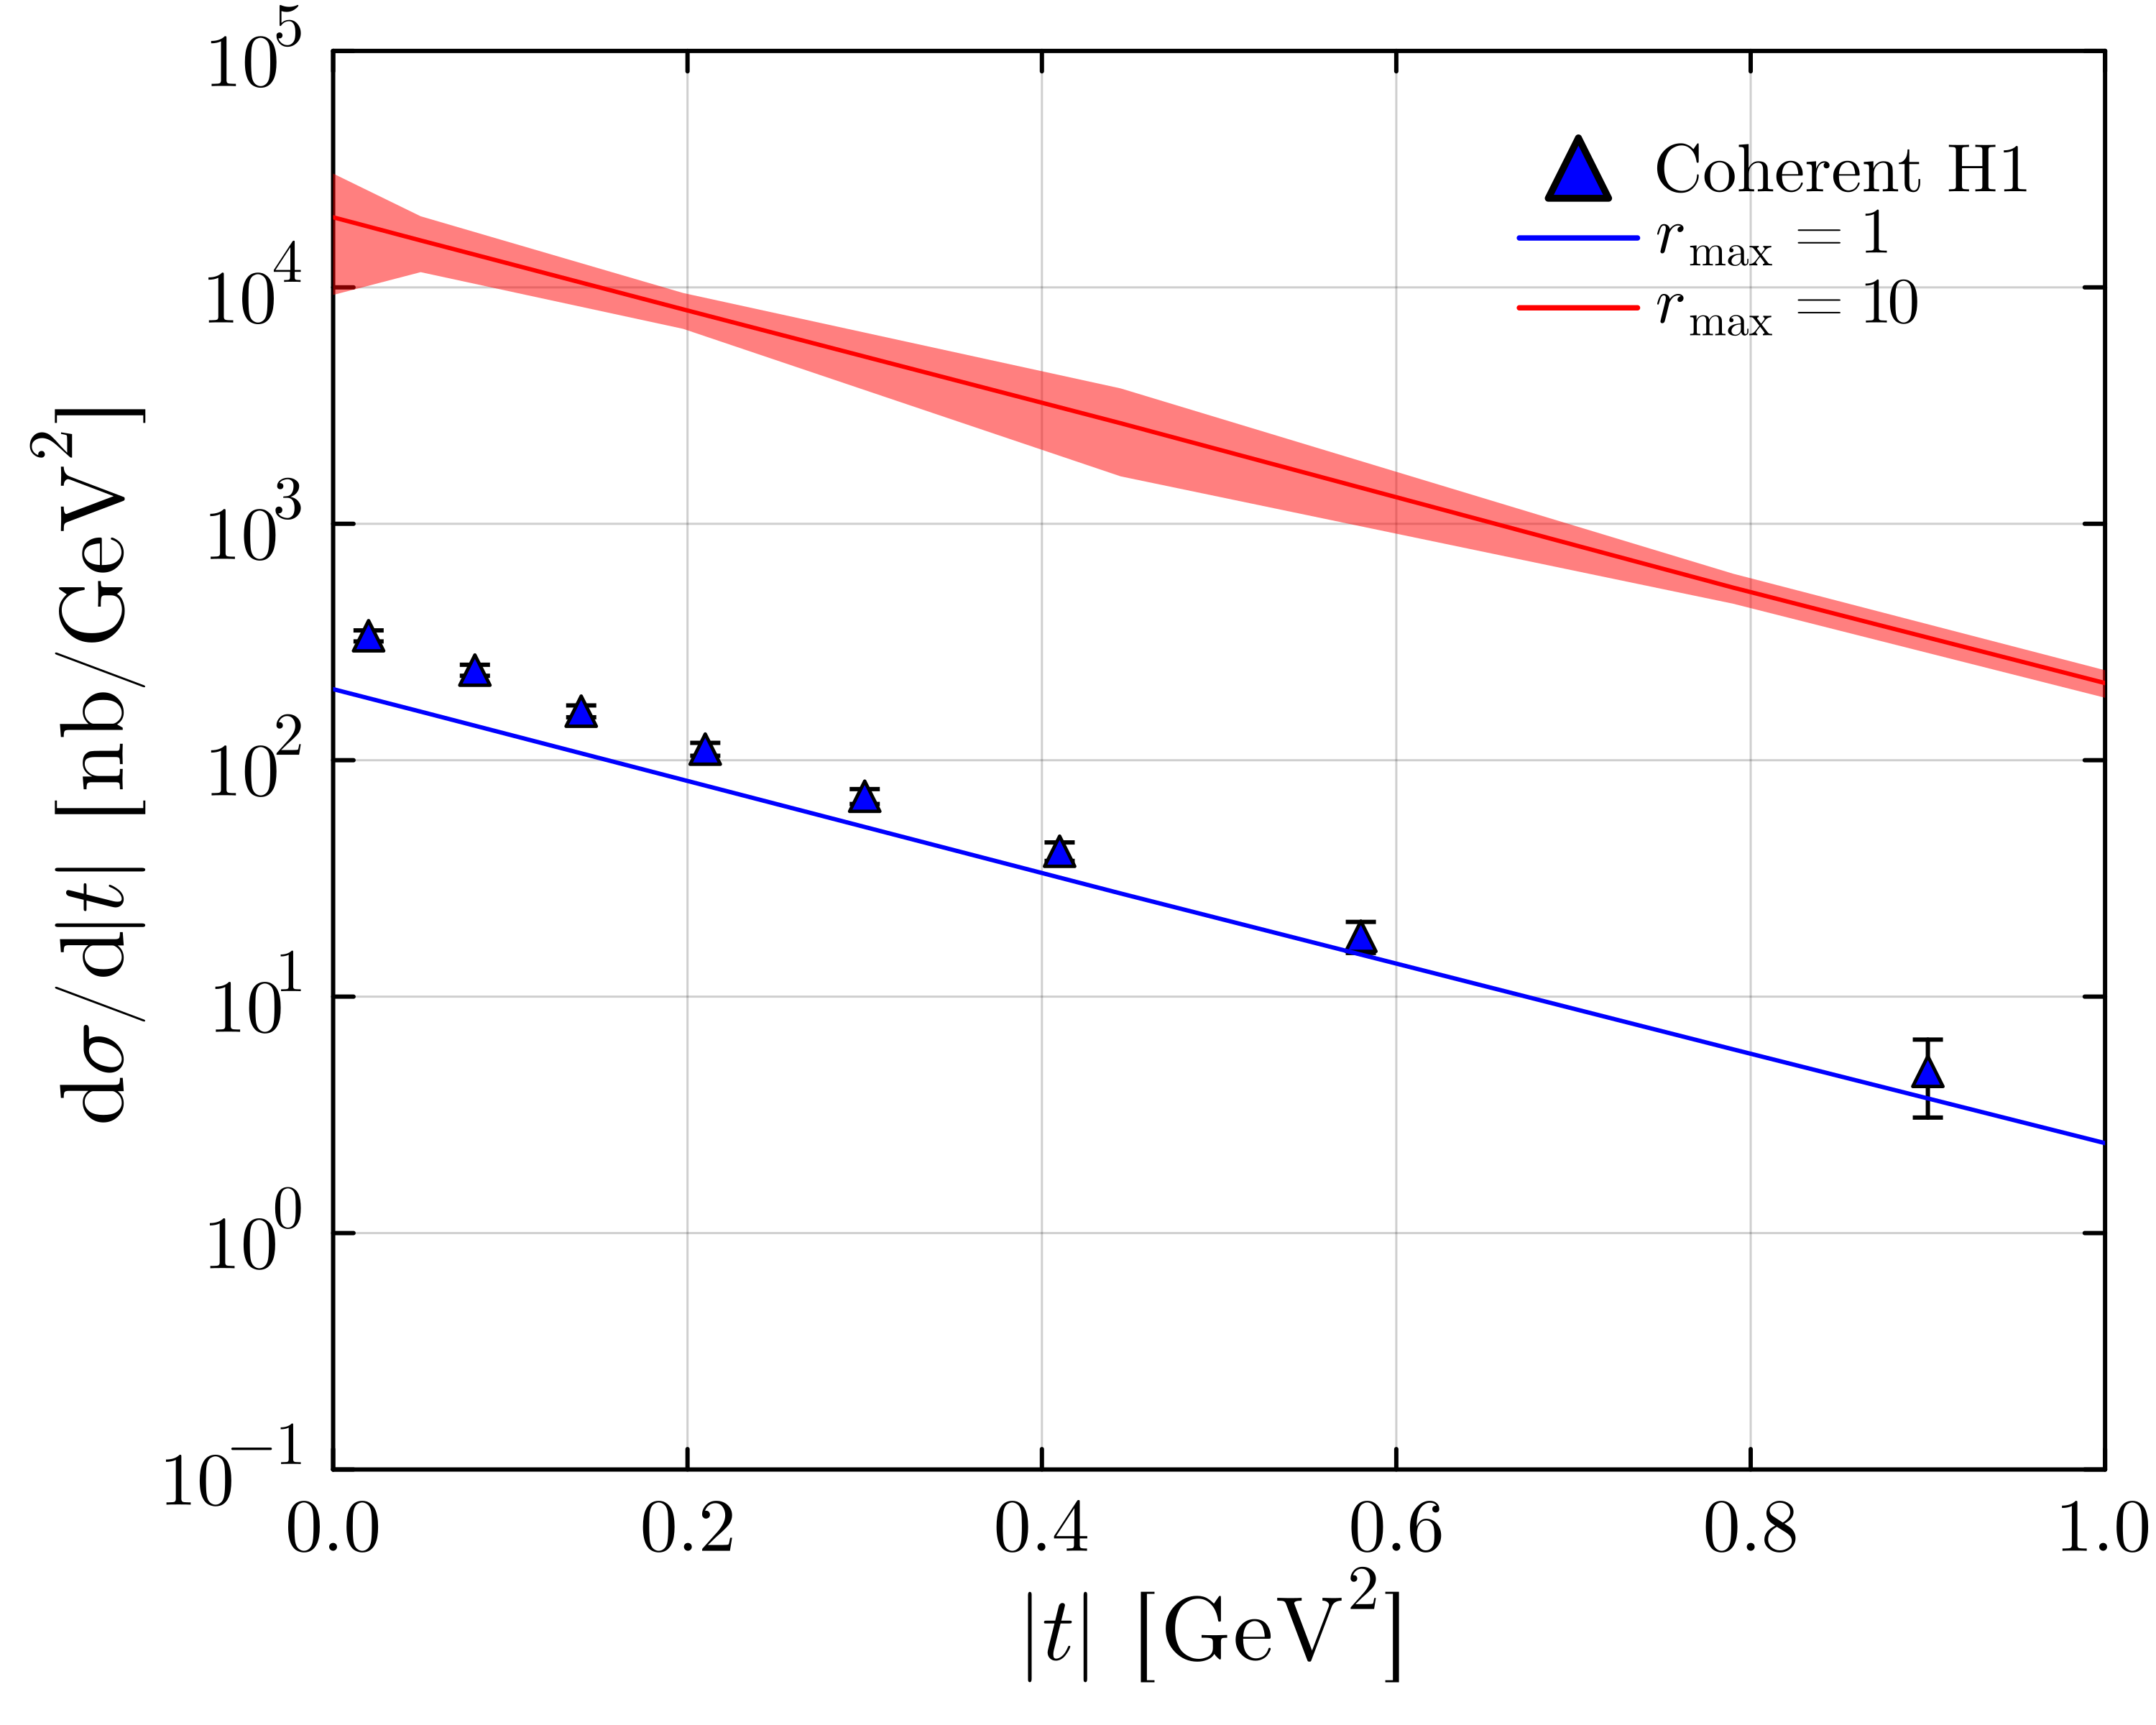

In [14]:
data_rmax_1 = CoherentMCData(t_range, dσdt_coh_rmax_1, abs2.(dσdt_coh_err_rmax_1), tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
data_rmax_10 = CoherentMCData(t_range, dσdt_coh_rmax_10, abs2.(dσdt_coh_err_rmax_10), tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera)
p = plot(data_rmax_1; custom_label = "\$r_{\\mathrm{max}} =1\$", color = :blue)
plot!(p, data_rmax_10; custom_label = "\$r_{\\mathrm{max}} =10\$", color=:red, hera=false)
ylims!(p, (0.1, 100000))
# annotate!(p, 0.28, 0.17, text(L"\mathrm{Fluctuation}~(3,3)~\mathrm{with}~\sigma=10", :black, 11))

---

In [4]:
using JLD2

In [5]:
data = JLD2.load("../results/cross_sections_m_3_nmax_3_find_norm_sigma_1.0_N0_1.3.jld2")

Dict{String, Any} with 5 entries:
  "dσdt_incoh_err" => [0.211787, 0.197797, 0.169615, 0.133482, 0.103608, 0.0785…
  "dσdt_coh_err"   => [0.211955, 0.200191, 0.177468, 0.14624, 0.125465, 0.09861…
  "t_range"        => [0.0, 0.0110803, 0.0443213, 0.099723, 0.177285, 0.277008,…
  "dσdt_coh"       => [324.844, 309.276, 265.89, 206.831, 145.33, 92.4635, 53.0…
  "dσdt_incoh"     => [0.0103377, 0.00968621, 0.0088542, 0.00772908, 0.00809657…

In [6]:
tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera = read_coherent_data("../data/jpsi_coh_hera.txt")
tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera = read_coherent_data("../data/jpsi_incoh_hera.txt")

([0.1, 0.29, 0.52, 0.78, 1.12, 1.55, 2.21, 3.3, 5.71], [47.3, 43.8, 36.7, 27.8, 16.8, 10.05, 6.04, 2.8, 0.875], [6.7, 6.0, 5.1, 4.2, 2.59, 1.56, 0.68, 0.38, 0.178])

In [ ]:
dσdt_incoh_err, dσdt_coh_err, t_range, dσdt_coh, dσdt_incoh = data["dσdt_incoh_err"], data["dσdt_coh_err"], data["t_range"], data["dσdt_coh"], data["dσdt_incoh"]
    
data_cohincoh = CohIncohMCData(t_range, dσdt_coh, dσdt_coh_err, dσdt_incoh, dσdt_incoh_err, tcent_coh_hera, dσdt_coh_hera, Δtot_coh_hera, tcent_incoh_hera, dσdt_incoh_hera, Δtot_incoh_hera)

p = plot(data_cohincoh)
ylims!(p, (0.001, 1000))